# 3) Test the selected model:"3-head Hydra model"

In [ ]:
%pylab inline
plt.style.use('seaborn-talk')

In [ ]:
# Check if we have a GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Google Collab root: '/content/gdrive/My Drive/TRANCOS'

In [ ]:
#Libraries required:

In [53]:
#import random
import glob
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import pandas as pd
import h5py
#from PIL import ImageStat
#import pickle
import time
import altair as alt
import math
import csv

import scipy
from scipy import stats

import skimage.io
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter 
from skimage.transform import resize
#from keras import backend as K

#import cv2


from matplotlib import pyplot as plt
from matplotlib import cm as CM

#from keras.preprocessing import image as kimage

#To preprocess images to fit VGG16 model:
#from keras.preprocessing.image import img_to_array, array_to_img
#from keras.applications.vgg16 import VGG16, preprocess_input

#To create Sequential model:
from keras import models

#To add layers to the model:
from keras import layers

#For augmentation purposes:
#from keras.preprocessing.image import ImageDataGenerator


#To set up the model and measurement:
#from keras import losses
#from keras import optimizers #SGD
#from keras import metrics
#from keras import initializers # For Back-end kernels Gaussian initialization with 0.01 standard deviation

from shutil import copyfile
import statsmodels.api as sm


To test the "3-head Hydra model", I will replicate the results on TRANCOS dataset from the test section of the paper  ('4.1 TRANCOS dataset') [^1], following 5 steps:<br>
[1. Data set (TRANCOS): download and setting links and path lists](#section_1)<br>
[2. Collecting functions required to run the "3-head Hydra model"](#section_2)<br>
[3. Loading trainned parameters (weights and biases) used in the paper](#section_3)<br>
[4. Testing the model and comparing the metrics to paper´s](#section_4)<br>
5. Additional analysis and comments.

<a id="section_1"></a>
## 1) Data set (TRANCOS): links and path lists

### 1.1) Download: 

To download TRANCOS dataset, I hihgly recommed to go DIRECTLY to the next link:
http://agamenon.tsc.uah.es/Personales/rlopez/data/trancos/TRANCOS_v3.tar.gz<br>

Note: I had problems to open some mask filters down loaded from other sources.

Ones dowloaded, save the folder "TRANCOS_V3" and its content directly on the "master" folder of this work.

***WARNING: The paths you will find below, to collect files from this dataset, are based on this structure.***

The information provided up to now is related to TRANCOS dataset and has been extracted from notebook ['ii_TRANCOS_db'](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/master/ii_TRANCOS_db.ipynb) of section '2.Dataset_ Selection and validation'.

In addition to TRANCOS, the main data set, a "sample" data set is provided (See "sample_data" folder).<br>
This "sample" data set is related to the "Fig. 5" of the paper[^1].<br>
This data set will be used to replicate that figure.
     

### 1.2) Links for test purposes:

In [2]:
root = './'
# Path to images folder 
test_path = root+'TRANCOS_v3/images'
# Path to data set to replicate "Fig.5" of the paper. 
sample_path = root+'sample_data'

### 1.3) Lists of paths for test purposes:

In [3]:
#List of images paths:

img_paths = []

for img_path in glob.glob(os.path.join(test_path,'image-3*.jpg')):
        img_paths.append(img_path.replace('\\','/'))

len(img_paths)

421

In [4]:
img_paths[:5]

['./TRANCOS_v3/images/image-3-000001.jpg',
 './TRANCOS_v3/images/image-3-000002.jpg',
 './TRANCOS_v3/images/image-3-000003.jpg',
 './TRANCOS_v3/images/image-3-000004.jpg',
 './TRANCOS_v3/images/image-3-000005.jpg']

In [5]:
#List of "sample" paths:
sample_paths = []

for img_path in glob.glob(os.path.join(sample_path,'image-3*.jpg')):
        sample_paths.append(img_path.replace('\\','/'))

len(sample_paths)

5

In [6]:
sample_paths

['./sample_data/image-3-000019.jpg',
 './sample_data/image-3-000049.jpg',
 './sample_data/image-3-000286.jpg',
 './sample_data/image-3-000340.jpg',
 './sample_data/image-3-000413.jpg']

<a id="section_2"></a>
## 2) Collect the functions required to run the "3-head Hydra model"
In accordance with the selection phase documentation (see ['i_model_selection.ipynb' notebook](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/master/i_model_selection.ipynb)), the 
functions required to run this model are:

In [7]:
def cartesian(arrays, out=None):
    """
    To be used in 1.1)
    Generates a cartesian product of input arrays.
    This function will provide a list of coordinates (positions) required by 'get_dense_pos' function (see below)
    to select those that will be used to build the patches (115x115).
    
    """    
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
            
    return out

In [8]:
def get_dense_pos(heith, width, pw, stride = 1):
    
    '''
    To be used in 1.1)
    
    The patches will be created by selecting points of the image as the center of the patch.
    Thus, the points of the image that generate patches whose coordinates go beyond the image´s perimeter 
    will not be selected.
    
    This function provides a dense list of points that will be used to build the patches (115x115).
    
    Those points will be selected from the area of the image whose points are at a distance from image´s perimeter 
    equal or higher than half of the patch height (or width), with a stride set by the 'stride' parameter 
    (stride=10 in Hydra model).
    
    @param heith: image height.
    @param width: image width.
    @param pw: patch with.
    @param stride: stride.
  
    '''    
    # Computes half a patch (height or width, it´s the same)
    dx=dy=int(pw/2)
    
    # Coordinates of the area of the image whose points are at a distance from its perimeter equal or higher
    #than half of a patch: 
    pos = cartesian( (range(dx, heith - dx, stride), range(dy, width -dy, stride) ) )
    bot_line = cartesian( (heith - dx -1, range(dy, width -dy, stride) ) )
    right_line = cartesian( (range(dx, heith - dx, stride), width -dy - 1) )
    
    return np.vstack( (pos, bot_line, right_line) )

In [9]:
def extractEscales(lim, n_scales, input_pw):
    '''  
    To be used in 1.2) and 1.3)
    
    Builds a 'pyramid' of different scale levels for each extracted patch, and
    resizes the crops (s_0, s_1 and s_2 in our case) to the input size to feed the Hydra_CNN.

    @param lim: list of patches related to the original image
    @param n_scales: number of different scale levels (3 in our case)
    @param input_pw: input size (72x72 pixels)
    
    '''
    out_list = [] #List of 'pyramids' corresponding to all the patches extracted from the original image
    for im in lim:
        ph, pw = im.shape[0:2] # it will get the patch width and height (115x115)
        scaled_im_list = [] #list of crops ('pyramid') related to a specific patch
        
        #Crops generator and resizing:
        for s in range(n_scales):
            ch = int(s * ph / (2*n_scales)) 
            cw = int(s * pw / (2*n_scales))
            
            crop_im = im[ch:ph-ch, cw:pw - cw]
            
            #s=0, s_0 = original patch = (115x115)
            #s=1, s_1 = 66% of original patch = (77x77)
            #s=2, s_2 = 33% of original patch = (39x39)
            
            #Resizes the crops (s_0, s_1 and s_2 in our case) to the input size to feed the Hydra_CNN (72x72)
            scaled_im_list.append(resize(crop_im, (input_pw, input_pw)))
        
        out_list.append(scaled_im_list)
        
    return out_list

In [10]:
def hydra_CNN():

### CCNN_s0:
    #Input:
    head0_input = layers.Input(shape=(3,72,72))
    #Conv1:
    head0 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head0_input)
    head0 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head0_conv1", data_format="channels_first")(head0)
    head0 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head0)
    #Conv2:
    head0 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head0)
    head0 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head0_conv2", data_format="channels_first")(head0)
    head0 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head0)
    #Conv3:
    head0 = layers.ZeroPadding2D(padding=(2, 2), data_format="channels_first")(head0)
    head0 = layers.Conv2D(64, kernel_size=5, activation='relu', name="head0_conv3", data_format="channels_first")(head0)
    #Conv4:
    head0 = layers.Conv2D(1000, kernel_size=1, activation='relu', name="head0_conv4", data_format="channels_first")(head0)
    #Conv5:
    head0 = layers.Conv2D(400, kernel_size=1, activation='relu', name="head0_conv5", data_format="channels_first")(head0)


### CCNN_s1:
    #Input:
    head1_input = layers.Input(shape=(3,72,72))
    #Conv1:
    head1 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head1_input)
    head1 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head1_conv1", data_format="channels_first")(head1)
    head1 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head1)
    #Conv2:
    head1 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head1)
    head1 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head1_conv2", data_format="channels_first")(head1)
    head1 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head1)
    #Conv3:
    head1 = layers.ZeroPadding2D(padding=(2, 2), data_format="channels_first")(head1)
    head1 = layers.Conv2D(64, kernel_size=5, activation='relu', name="head1_conv3", data_format="channels_first")(head1)
    #Conv4:
    head1 = layers.Conv2D(1000, kernel_size=1, activation='relu', name="head1_conv4", data_format="channels_first")(head1)
    #Conv5:
    head1 = layers.Conv2D(400, kernel_size=1, activation='relu', name="head1_conv5", data_format="channels_first")(head1)


### CCNN_s2:
    #Input:
    head2_input = layers.Input(shape=(3,72,72))
    #Conv1:
    head2 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head2_input)
    head2 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head2_conv1", data_format="channels_first")(head2)
    head2 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head2)
    #Conv2:
    head2 = layers.ZeroPadding2D(padding=(3, 3), data_format="channels_first")(head2)
    head2 = layers.Conv2D(32, kernel_size=7, activation='relu', name="head2_conv2", data_format="channels_first")(head2)
    head2 = layers.MaxPooling2D(pool_size=2, strides=2, data_format="channels_first")(head2)
    #Conv3:
    head2 = layers.ZeroPadding2D(padding=(2, 2), data_format="channels_first")(head2)
    head2 = layers.Conv2D(64, kernel_size=5, activation='relu', name="head2_conv3", data_format="channels_first")(head2)
    #Conv4:
    head2 = layers.Conv2D(1000, kernel_size=1, activation='relu', name="head2_conv4", data_format="channels_first")(head2)
    #Conv5:
    head2 = layers.Conv2D(400, kernel_size=1, activation='relu', name="head2_conv5", data_format="channels_first")(head2)

#Note: Caffe uses a "channel_first" format for inputs.

## Concatenation of outputs from the CCNN layers (s0, s1 and s2):
    body = layers.concatenate([head0, head1, head2], axis=1)
    body = layers.Flatten()(body)
#Note: A 'Flatten' layer is added, which it´s not mentioned in the paper, 
#to be able to feed the fully-connected layers properly. 


## Fully-connected layers:
    #Fc6:
    body = layers.Dense(512, activation='relu', name="body_fc6")(body)
    #Fc7:
    body = layers.Dense(512, activation='relu', name="body_fc7")(body)
    #Fc8:
    body = layers.Dense(324, activation='relu', name="body_fc8")(body)


## Model definition:
    hydra_CNN_model = models.Model(inputs=[head0_input, head1_input, head2_input], outputs=body)

    return hydra_CNN_model


In [11]:
def resizeDensityPatch(patch, opt_size):
    '''
    Takes a density map and resizes it to the opt_size.
    
    @param patch: input density map.
    @param opt_size: output size (the original size of the patch, 115x115, in our case).
        
    The rescaling process will generate a density map whose associated count (pixel values addition) will not
    necessarily match the count of the input density map.
    Therefore, the input density map will be normalized before rescaling, reversed after rescaling
    and the final count adjusted.
    
    '''
       
    # Input normalization to values between 0 and 1:
    patch_sum = patch.sum()   
    p_max = patch.max()
    p_min = patch.min()    
    if patch_sum !=0: # Avoid 0 division
        patch = (patch - p_min)/(p_max - p_min)
    
    # Resizing to the original size of the patch:
    patch = resize(patch, opt_size)
    
    # Normalization reversal:
    patch = patch*(p_max - p_min) + p_min
    
    # Count adjustment:
    res_sum = patch.sum()
    if res_sum != 0:
        return patch * (patch_sum/res_sum)

    return patch

The final function to run the model is as follows:

In [12]:
#Hydra model processing:

def process(model, im, n_scales, base_pw, input_pw):
    
    '''
    Parameters (values based on the paper´s methodology):
    model: model to be used for density map prediction purposes (3-head Hydra_CNN)
    im: image from which a density map will be estimated
    n_scales: number of different scale levels to feed the Hydra_CNN as inputs (for the 3-head Hydra_CNN, 
                there will be 3: s:0, s_1, s_2)
    base_pw: original size of patches to be extracted from the image (115x115 pixels)
    inpu_pw: inputs size (72x72 pixels)
    
    '''
#1) Data preprocessing: original image descomposition into 115x115 overlapped patches
    #Steps:
    
    #1.1) From the original image, extract all the consecutive 115x115 patches with a stride of 10 pixels: 
            
    # Obtaining a dense list of points (coordinates) from the image that will be used to build the patches (115x115)
    [heith, width] = im.shape[0:2]
    pos = get_dense_pos(heith, width, base_pw, stride=10) #Stride=10

    # Initialize density matrix and votes counting
    dens_map = np.zeros( (heith, width), dtype = np.float32 )  
    count_map = np.zeros( (heith, width), dtype = np.int32 )  
                
    for ix, p in enumerate(pos): # Iterate for all patches            
        dx=dy=int(base_pw/2) # Compute displacement from centers
        x,y=p
        sx=slice(x-dx, x+dx+1, None)
        sy=slice(y-dy, y+dy+1, None)
        crop_im=im[sx,sy,...]
        h, w = crop_im.shape[0:2]
        if h!=w or (h<=0):
            continue
    #1.2) Build a 'pyramid' of 3 different scale levels ('s') for each extracted patch, and,
    #1.3) Resize s_0, s_1 and s_2 to 72x72 pixels to feed the Hydra_CNN.
           
        im_scales = extractEscales([crop_im], n_scales, input_pw)
                        
        head0_input = np.expand_dims(im_scales[0][0].copy().transpose(2,0,1), axis=0)
        head1_input = np.expand_dims(im_scales[0][1].copy().transpose(2,0,1), axis=0)
        head2_input = np.expand_dims(im_scales[0][2].copy().transpose(2,0,1), axis=0)
            
#2) 3-head Hydra_CNN processing: Obtaining densitiy map prediction for each 115x115 patch         
        pred = model.predict([head0_input,  head1_input,  head2_input])

#3) Density map assembly: Assembly of all the predicted maps to get the density map for the whole original image

    #3.1) Reshape&resize Hydra_CNN´s outputs to get the density map for each patch:
        #Rashape to a 2-dimention array
        p_side = int(np.sqrt( len( pred.flatten() ) )) 
        pred = pred.reshape(  (p_side, p_side) )
            
            # Resize it back to the original patch size (115x115 pixels)
        pred = resizeDensityPatch(pred, crop_im.shape[0:2])          
        pred[pred<0] = 0

    #3.2) Assembly of all patches density map estimations:
        # Predicted density map for each patch is added to the total density map:
        dens_map[sx,sy] += pred
        #Since overlapping occurs, a matrix is Summing up the times (votes) each coordinate has been predicted, 
        #for afterwards average calculation purposes:
        count_map[sx,sy] += 1

    # Remove Zeros
    count_map[ count_map == 0 ] = 1

    # Final average density map for the whole original image:
    dens_map = dens_map / count_map        
        
    return dens_map

<a id="section_3"></a>
## 3) Load trainned parameters (weights and biases) used in the paper 
The trainned parameters used in the paper and available on GitHub: 
['https://github.com/gramuah/ccnn'](https://github.com/gramuah/ccnn) <br>

Since the paramemter avaible on GitHub are Caffe-based coded, I had to find the way to translate them from Caffe code to Keras code.

***NOTES:*** <br>
Parameters and related files are saved on ['model_parameters'](https://github.com/jorgealcubilla/TFM_DataScience/tree/master/model_parameters) folder.

<font color=red>***To complete the documentation required by this section, YOU MUST:***

***1) DOWNLOAD two additional files named:***<br>
    ***- model_w.h5***<br>
    ***- trancos_hydra3.caffemodel***<br>
***They can be collected from: 
https://drive.google.com/drive/folders/1lRz9DlQNcASu2fuLckNjnBxkCT8lHBez?usp=sharing***<br>
***2) SAVE these files into the folder included in this project named 'model_parameters'.***
</font>

The mentioned parameters (weights and biases) were converted using functions obtained from the GitHub project ['caffe_weight_converter'](https://github.com/pierluigiferrari/caffe_weight_converter) by Pierluigi Ferrari.
 
The steps I followed can be found in the jupyter notebook included in this project, named: ["caffe_weights_to_tf"](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/model_parameters/caffe_weights_to_tf.ipynb)<br>
Basically, these steps are:
- Open a notebook with Google_Colaboratory (https://colab.research.google.com/notebooks/welcome.ipynb)
- Install a CPU version of a caffe library for python: caffe-cpu (you can also find how to install a GPU version)
- Collect files containing Caffe model information.
    These files consist of:
        - `.prototxt` file which defines the Caffe model ('trancos_hydra3.caffemodel')
        - `.caffemodel` file which contains the weights for the Caffe model ('hydra3_deploy.prototxt').
Both files were previously downloaded from the Github project of the paper onto a Google_Drive folder.<br>
If the instructions provided in "NOTES" above have been followed properly, both files will be already availabe in  ['model_parameters'](https://github.com/jorgealcubilla/TFM_DataScience/tree/master/model_parameters) folder of this project.
- Save these files in a Google_Drive folder.
- Set the path to those files ("root").
- Get "convert_caffemodel_to_keras" function, necessary code and libraries from the aforementioned "caffe_weights_to_tf" GitHub project by Pierluigi Ferrari.
- Use that function to translate parameters for "3-head hydra_CNN" with Caffe structure into Keras.  
<br>
<br>

Running ["caffe_weights_to_tf"](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/model_parameters/caffe_weights_to_tf.ipynb) in Google_Collaboratory with Caffe model files ('trancos_hydra3.caffemodel' and 'hydra3_deploy.prototxt') available on Google_Drive, as explained above, the 'model_w.h5' file with the parameters will be created and saved on the "root" path.

If the instructions provided in "NOTES" above have been followed properly, 'model_w.h5' will be already available in  ['model_parameters'](https://github.com/jorgealcubilla/TFM_DataScience/tree/master/model_parameters) folder of this project.

<font color=red>*** WARNING: CODE BELOW REQUIRES 'model_w.h5' FILE, AVAILABLE AND PROPERLY SAVED *** </font> 


Now, I will load the parameters into a "3-head Hydra_CNN" instance to check whether the paramenters are loaded properly.
First, I create an instance called "hydra_sample":

In [13]:
hydra_sample =  hydra_CNN()

Then, I load the paramenter into the instance:

In [14]:
hydra_sample.load_weights('./model_parameters/model_w.h5', by_name=True)

And then, I will compare the parameters coming from "hydra_sample" to those coming from the convertion file ('model_w.h5'), by
calculating the sum of both sets of parameters as follows:

In [15]:
#Addition of parameters from "hydra_sample": 

hydra_parameters = hydra_sample.get_weights()
hydra_parameters_sum = 0

for n in range(len(hydra_parameters)):
    hydra_parameters_sum += np.sum(hydra_parameters[n])

hydra_parameters_sum

-1313.910742297594

In [16]:
#Addition of parameters from translation file: 
#It will take some steps:

#Read the file and its keys:
file_parameters = h5py.File('./model_parameters/model_w.h5', 'r')
#A list of its keys is created for further use:
list_key = list(file_parameters.keys())
list_key

['body_fc6',
 'body_fc7',
 'body_fc8',
 'head0_conv1',
 'head0_conv2',
 'head0_conv3',
 'head0_conv4',
 'head0_conv5',
 'head1_conv1',
 'head1_conv2',
 'head1_conv3',
 'head1_conv4',
 'head1_conv5',
 'head2_conv1',
 'head2_conv2',
 'head2_conv3',
 'head2_conv4',
 'head2_conv5']

In [17]:
#".h5" files are structured as a system of "folders" called "groups" and "subgroups".

#Let´s check our file´s structure:
def printname(name):
    print(name)
file_parameters.visit(printname)
    

body_fc6
body_fc6/body_fc6
body_fc6/body_fc6/bias:0
body_fc6/body_fc6/kernel:0
body_fc7
body_fc7/body_fc7
body_fc7/body_fc7/bias:0
body_fc7/body_fc7/kernel:0
body_fc8
body_fc8/body_fc8
body_fc8/body_fc8/bias:0
body_fc8/body_fc8/kernel:0
head0_conv1
head0_conv1/head0_conv1
head0_conv1/head0_conv1/bias:0
head0_conv1/head0_conv1/kernel:0
head0_conv2
head0_conv2/head0_conv2
head0_conv2/head0_conv2/bias:0
head0_conv2/head0_conv2/kernel:0
head0_conv3
head0_conv3/head0_conv3
head0_conv3/head0_conv3/bias:0
head0_conv3/head0_conv3/kernel:0
head0_conv4
head0_conv4/head0_conv4
head0_conv4/head0_conv4/bias:0
head0_conv4/head0_conv4/kernel:0
head0_conv5
head0_conv5/head0_conv5
head0_conv5/head0_conv5/bias:0
head0_conv5/head0_conv5/kernel:0
head1_conv1
head1_conv1/head1_conv1
head1_conv1/head1_conv1/bias:0
head1_conv1/head1_conv1/kernel:0
head1_conv2
head1_conv2/head1_conv2
head1_conv2/head1_conv2/bias:0
head1_conv2/head1_conv2/kernel:0
head1_conv3
head1_conv3/head1_conv3
head1_conv3/head1_conv3/bia

In [18]:
#I will go through the file´s struture, summing up data from each "subgroup":

file_parameters_sum = 0

for n in list_key: # The list of keys, generated above, will provide the name of the "groups/subgroup" where 
                    #the information of each layer is stored
    file_parameters_sum += sum(file_parameters[n][n]['bias:0']) #Bias "subgroup"
    file_parameters_sum += sum(np.asarray(file_parameters[n][n]['kernel:0']).flatten()) #Weights "subgroup"
    
file_parameters_sum

-1313.9089691040606

In [19]:
#Finally, I compare both additions: 
hydra_parameters_sum-file_parameters_sum

-0.0017731935333813453

Since the difference is no relevant, we can conclude that the parameters extracted from the Caffe model
have been loaded into the keras model successfully!!!

Let´s have a look at some layers and check whether parameters have been loaded:

In [20]:
hydra_sample.get_layer('head0_conv1').get_weights()

[array([[[[ 2.53089052e-03, -1.61620544e-03, -2.14723055e-03, ...,
           -1.75789453e-03,  8.25904834e-04, -8.61892663e-03],
          [ 6.73045579e-04, -2.60749320e-03, -7.02348363e-04, ...,
            4.91004030e-04, -2.30485588e-04, -2.14579282e-03],
          [ 4.52766847e-03, -1.56349118e-03,  1.16221629e-04, ...,
            2.62325280e-04, -8.08410987e-05, -2.81005749e-03]],
 
         [[ 9.72260546e-04, -1.21560390e-03, -7.17733883e-06, ...,
            1.91676477e-03,  1.68296956e-05, -4.84507810e-03],
          [-4.57469927e-04, -2.77786050e-03,  5.65601629e-04, ...,
           -1.33594638e-03,  9.29203874e-04,  9.88506014e-04],
          [ 5.52018685e-03, -5.31367434e-04, -1.45298208e-03, ...,
            5.58348656e-05,  1.66971772e-03,  9.20615101e-04]],
 
         [[-1.17572024e-04, -1.94525893e-03, -2.37982400e-04, ...,
            3.14453384e-04,  1.85453275e-03, -4.11272608e-03],
          [ 2.21199472e-04, -1.24488492e-03,  2.02519674e-04, ...,
           -1.121

In [21]:
hydra_sample.get_layer('head1_conv3').get_weights()

[array([[[[-8.44418653e-04, -9.89083710e-05,  2.43992312e-04, ...,
           -2.30984981e-04,  8.02251219e-04, -2.42967578e-03],
          [ 1.01295928e-03, -1.33867215e-05, -4.30333574e-04, ...,
           -2.38441280e-04, -3.75165197e-04, -1.58645841e-03],
          [ 5.21675625e-04, -4.20418364e-04, -6.08596194e-04, ...,
           -6.84117025e-04, -6.94153656e-04,  4.64843295e-04],
          ...,
          [ 9.78561235e-04,  6.44056825e-04,  7.65844830e-04, ...,
            5.66594361e-04,  6.10594638e-04,  1.00312333e-04],
          [ 7.55194516e-04,  1.79052135e-04,  1.10800867e-03, ...,
            8.27092736e-04, -1.42713962e-03, -2.53971491e-04],
          [-2.00076005e-03, -7.22062396e-05, -9.95184455e-05, ...,
           -4.44769656e-04, -4.17551026e-04,  9.85442661e-04]],
 
         [[-1.13088614e-03, -5.72185731e-04, -9.37309451e-05, ...,
           -2.07494202e-04, -6.15202531e-04,  6.45197579e-04],
          [ 1.74322966e-04,  6.11836440e-04, -5.26991964e-04, ...,
     

In [22]:
hydra_sample.get_layer('head2_conv3').get_weights()

[array([[[[ 3.90811474e-04,  8.17353604e-04, -3.09491843e-05, ...,
           -6.15062774e-04, -4.61231510e-04,  7.22802710e-04],
          [-1.01841008e-03, -2.15582456e-03, -7.82544725e-04, ...,
            1.15343835e-03,  3.66200140e-04, -5.71240162e-05],
          [-5.31424477e-04, -1.54100510e-03,  4.33708570e-04, ...,
           -1.62232900e-04, -1.19101128e-03, -1.78779810e-04],
          ...,
          [ 1.23789604e-03, -1.14217272e-03,  6.42522820e-04, ...,
            5.39590314e-04, -1.13746454e-03,  5.04585681e-04],
          [ 1.11537834e-03, -9.37304518e-04,  4.09770466e-04, ...,
            3.46913148e-04, -5.22975693e-04,  2.98274303e-04],
          [-4.41064156e-04, -3.97256255e-04, -1.02670951e-04, ...,
           -2.26195599e-03,  4.42699617e-04,  5.56096900e-04]],
 
         [[-2.31595361e-03, -8.23500915e-04,  2.17892509e-03, ...,
           -1.45636313e-03, -9.86637897e-04, -7.04274164e-04],
          [-7.73609965e-04,  5.38149150e-04,  4.91382612e-04, ...,
     

In [23]:
hydra_sample.get_layer('body_fc6').get_weights()

[array([[-0.41189203,  0.15042493, -0.23065646, ...,  0.2280351 ,
          0.09112228,  0.3557022 ],
        [-0.32463202, -0.150886  ,  0.3370405 , ...,  0.07737508,
         -0.00777615,  0.26460868],
        [-0.01862993, -0.2003184 , -0.04197997, ..., -0.22741613,
          0.2934121 ,  0.02604242],
        ...,
        [-0.10399969,  0.2485705 ,  0.17898823, ..., -0.15031031,
         -0.4310816 , -0.17120862],
        [-0.03589224,  0.09971698, -0.0376261 , ...,  0.0153896 ,
          0.13342851, -0.18715897],
        [-0.18102758,  0.11957613, -0.30434   , ..., -0.00976873,
          0.29906625, -0.00136238]], dtype=float32),
 array([-4.13582724e-09, -8.02257091e-06, -1.13883561e-05,  4.74994667e-05,
        -1.29590335e-05, -3.30050643e-05, -5.88071744e-05, -4.83354706e-05,
         1.32877931e-05,  6.13925477e-06, -2.95278642e-05, -7.27018996e-05,
         2.30425157e-05,  3.63186700e-05,  2.71930003e-05,  6.41995985e-06,
        -7.07374129e-05,  2.86220838e-05, -2.36794785e

In [24]:
hydra_sample.get_layer('body_fc7').get_weights()

[array([[-0.3172347 , -0.06928265,  0.18981223, ..., -0.12378509,
         -0.14328365, -0.05607724],
        [-0.08540403, -0.09992646, -0.10236683, ...,  0.3636013 ,
          0.10649987,  0.41749468],
        [ 0.3053793 , -0.02405066, -0.10935896, ..., -0.17837687,
         -0.19769183,  0.03241426],
        ...,
        [ 0.46465576,  0.04951782, -0.34166974, ..., -0.07883261,
          0.0163533 , -0.02880956],
        [ 0.08104658,  0.1575151 ,  0.02626101, ...,  0.16542839,
          0.06660704, -0.51142186],
        [-0.05408786,  0.19875869, -0.13783753, ...,  0.10826465,
         -0.13400389, -0.2910896 ]], dtype=float32),
 array([ 3.11610347e-06,  3.07603000e-06, -1.37052621e-05,  6.29949272e-06,
         4.67241762e-07,  1.11695613e-06,  2.19785875e-06, -1.53473720e-05,
         8.83387929e-06,  2.14482861e-06, -1.86251837e-05, -1.52069356e-06,
         1.74214995e-06,  3.12573843e-06,  1.20243172e-07,  1.62992837e-05,
        -4.17292358e-06, -7.94026982e-06, -8.51485856e

In [25]:
hydra_sample.get_layer('body_fc8').get_weights()

[array([[ 1.0067141e-05,  9.2824675e-06,  1.0982622e-05, ...,
         -1.9710566e-05, -2.5058365e-05, -2.4269051e-05],
        [ 1.7145183e-04,  1.6396397e-04,  1.4498530e-04, ...,
          4.1724902e-04,  4.3724023e-04,  4.4501957e-04],
        [-5.4578497e-05, -8.8513218e-05, -1.3160941e-04, ...,
          1.4305649e-04,  1.0257335e-04,  9.3424838e-05],
        ...,
        [-8.2118459e-05, -8.6687003e-05, -8.3935010e-05, ...,
          1.7859238e-05,  1.8319754e-05,  1.5131844e-05],
        [ 1.8299260e-04,  1.5608028e-04,  1.0580324e-04, ...,
          6.7735050e-06, -3.0650135e-05, -4.0050119e-05],
        [-3.0225024e-04, -2.6698608e-04, -2.1538252e-04, ...,
          4.5821071e-04,  4.5359053e-04,  4.3761451e-04]], dtype=float32),
 array([9.70064139e-05, 8.80150765e-05, 9.50865069e-05, 1.14530041e-04,
        1.41486482e-04, 1.72000946e-04, 2.02425741e-04, 2.29440077e-04,
        2.49821955e-04, 2.63115042e-04, 2.72226025e-04, 2.82624824e-04,
        2.98142404e-04, 3.19278450

Yes, there they are!!!

<a id="section_4"></a> 
## 4) Testing the model and comparing the metrics to paper´s

The model is trainned to reproduce a density map of the original image whose addition of values ("pixels") is the 
total number of annotated objects.
Thus, the target used by the model is a **density map** of the original image.

- **Metric**:<br>
The mean absolute error (MAE) will be the metric used to evaluate the model performance.<br>
<br>

- **Definitions:**
    - Region of interest (ROI): area of the original image subject to evaluation ("XXXmask.mat" file, see "1.1.Description").
    - Input: original image ("XXX.jpg" file, see "1.1.Description").
    - Ground_truth: Addition of values of the input´s density map, restricted to its ROI.
      The input´s density map will be obtained from its corresponding image of annotated objects 
      ("XXXdot.png", see ["TRANCOS dataset description"](https://github.com/jorgealcubilla/TFM_DataScience/blob/master/ii_TRANCOS_db.ipynb))
    - Prediction: Addition of values of the density map, predicted by the "3-head Hydra_CNN", for the input restricted to its ROI.

**MAE metric will calculate the difference between ground_truths and predictions for a given set of images.**


Some additional functions will be required for testing purposes:
- "genDensity":function to obtain the density map of annotated objects (vehicles), which will be used as the model´s target.
- "hydra_testing": it uses the rest of the defined functions to run the model over a given image or a list of images, returning a 'csv' file with all the necessary data to test the model performance. 


In [26]:
def genDensity(dot_im, sigmadots):
    '''
    @brief: This function gets a dotted image and returns its density map.
    @param: dots: annotated position of objects consisting of image of dots.
    @param: sigmadots: density radius.
    @return: density map for the input dots image.
    '''
    
    # Takes only red channel
    dot = dot_im[:, :, 0]
    dot = gaussian_filter(dot, sigmadots)
        
    return dot.astype(np.float32)

In [27]:
def hydra_testing(img_paths, n_scales, base_pw, input_pw, sigmadots):
    ''' 
    @brief: This function runs the model over a given image or a list of images, 
            returning a 'csv' file with all the necessary data to test the model performance. 
            The data returned are:
                "Input" reference, see definition above 
                Total number of annotated objects,
                "Ground_truth", see definition above
                "Prediction", see definition above
                
    @param: img_paths: input for the Hydra_CNN consisting of an image or a list of images        
    @param: n_scales: number of different scale levels to feed the Hydra_CNN as inputs (for the 3-head Hydra_CNN, 
                there will be 3: s:0, s_1, s_2)
    base_pw: original size of patches to be extracted from the image (115x115 pixels)
    inpu_pw: inputs size (72x72 pixels)    
    @param: sigmadots: density radius.
    

    '''
    #Opens a file that will be used to save the data required for model performance analysis.
    ## The required data are: "Input" reference (img_number), Total number of annotated objects (ndots),
    ##"Ground_truth" (ntrue) and "Prediction" (npred).
    with open(root+'test.csv', 'w') as csv_file: 
        field_names = "img,ndots,ntrue,npred\n"
        csv_file.write(field_names)

    #Iterates over a list of images
        for im_path in img_paths:
        
            s=time.time() #Measures time spend on running the model on each image
    
            #Reads the image of annotated objects
            dot_im_path = im_path.replace('.jpg','dots.png')
            dot_im = skimage.img_as_float(skimage.io.imread(dot_im_path, as_grey=not True)).astype(np.float32)
            #Reads the input (original image)
            im = skimage.img_as_float(skimage.io.imread(im_path)).astype(np.float32)
        
    
            #Generates input´s density map:
            dens_im = genDensity(dot_im, 15) #See function above
    
            # Reads the mask that will be applied to images to get their ROI (Region Of Interest)
            mask_im_path = im_path.replace('.jpg','mask.mat')
            mask = sio.loadmat(mask_im_path, chars_as_strings=1, matlab_compatible=1)
            mask = mask.get('BW')
    
            #Gets input´s density map:
            #CNN setup:
            hydra = hydra_CNN() 
            parameters_path = os.path.join(root, "model_parameters", "model_w.h5") #Path to model´s trainned parameters
            hydra.load_weights(parameters_path, by_name=True)#Loads trainned parameters into the model
            #Running 3-head Hydra model on input:
            resImg = process(hydra, im, n_scales, base_pw, input_pw) # 

            # Applies mask to retrict density maps to the ROI:
            resImg = resImg * mask #On prediction´s
            dens_im = dens_im * mask #On input´s
        
            # Data required for model performance analysis (see above):    
            npred=resImg.sum()
            ntrue=dens_im.sum()
            ndots = dot_im.sum()
            img_number = str(im_path[-12:-4])
    
            #Saves individual data in the file that was opened at the begining:
            row = img_number + "," + str(ndots) + "," + str(ntrue) + "," + str(npred) + "\n"  
            csv_file.write(row)     
    
    
            print("image# %s: ndots = %.2f, ntrue = %.2f, npred = %.2f, time =%.2f sec"%(img_number,ndots,ntrue,npred,time.time()-s))
    
   
        csv_file.close() #Just in case ...
   
        print("Finished!")


As the model has to be run on a significant amount of images (421), it will be run by batches in order to minimize the lost of outputs if the process unexpectctedly stops.<br>
If that happens, the code below will allow us to resume the process from the last batch completed.<br>
Besides, every completed batch will be saved.

Then, let´s run the model and collect data by batches as follows:

In [28]:
batch_size = 30 #Sets the size of batches
i1 = 0 #Starting item for each batch
test_total = 421 #Total number of items to be tested 
path = root ##Poner el definitivo!!!!!!
test_csv = root+'test.csv' #path to the file where data generated by "hydra_testing" function is saved

#Batch iteration on data generation&collection for test purposes:  
while i1 < test_total:    
  
    if i1+batch_size < test_total:
        i2 = i1+batch_size
    else:
        i2 = test_total
  
    print(i1,'-', i2-1,'/',test_total)
            
    file_name = os.path.join(path, 'batch_'+str(i1)+'.csv')
  
                  
    img_batch = img_paths[i1:i2]
    hydra_testing(img_batch, 3, 115, 72, 15)# Data generation
        #Function parameters setting based on model´s specifications (See "i_model_selection" notebook for explanations)
        #base_pw = 115
        #n_scales = 3
        #sigmadots = 15 
        #input_pw = 72
  
    with open(file_name, 'w') as csv: 
        copyfile(test_csv, file_name) #The file created by the "hydra_testing" function is used as a "temporary" file while 
        #data is being generated for a batch. When the process is finished, the data related to that batch are saved
        #on another file which is specific for each batch.
        csv.close() 
        os.remove(test_csv) # Ones all data from this "temporary" file have been copied onto the specific batch file, it is 
                            #removed.
    
            
    i1 += batch_size


0 - 29 / 421


C:\Users\JORGE\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

Ones the batches have been created, all of them are gathered in a single "csv" file.
Since it´s

#Only the firt time

batches_path = root+'test_batches'
batches_df = [] 
concat_path = batches_path+'/batches_total.csv' #Path to the file that includes data from all the batches

for batch in glob.glob(os.path.join(batches_path,'*.csv')):
    print(batch)
    df = pd.read_csv(batch, header=0)
    batches_df.append(df)
concatenation = pd.concat(batches_df, axis=0)

if os.path.exists(concat_path):
    os.remove(concat_path)

concatenation.to_csv(concat_path, index=None)    

Then, we read the new "csv" file that includes all the data and check that all the data we need is there

In [29]:
batches_path = root+'test_batches'
concat_path = batches_path+'/batches_total.csv'
csv_test = pd.read_csv(concat_path)
csv_test.head()

,img,ndots,ntrue,npred
0,3-000421,35.0,33.091682,51.260645
1,3-000420,45.0,43.518074,41.013837
2,3-000419,38.0,35.039540,34.221519
3,3-000418,33.0,31.251856,37.867658
4,3-000417,41.0,38.688330,38.268263


In [30]:
len(csv_test)

421

Now, we start the process to calculate the MAE metrix for the test data_set.
First, we calculate the absolute error for each prediction:

In [31]:
csv_test['error'] = abs(csv_test.ntrue-csv_test.npred)

Then, we sum up all the errors

In [32]:
#MAE:
sum(csv_test['error'])/len(csv_test)

10.905642386956973

The result is the same as the one that can be found in the paper (Hydra_3s: MAE = GAME_0 = 10.99)

Thus, **we have another solid evidence to support that "3-head Hydra model" has been replicated properly.**


In [33]:
def hydra_testing_df(img_paths, n_scales, base_pw, input_pw, sigmadots):
    ''' 
    @brief: This function runs the model over a given image or a list of images, 
            returning a 'data frame' with all the necessary data to test the model performance. 
            The data returned are:
                "Input" reference, see definition above 
                Total number of annotated objects,
                "Ground_truth", see definition above
                "Prediction", see definition above
                
    @param: img_paths: input for the Hydra_CNN consisting of an image or a list of images        
    @param: n_scales: number of different scale levels to feed the Hydra_CNN as inputs (for the 3-head Hydra_CNN, 
                there will be 3: s:0, s_1, s_2)
    base_pw: original size of patches to be extracted from the image (115x115 pixels)
    inpu_pw: inputs size (72x72 pixels)    
    @param: sigmadots: density radius.
    

    '''
    #Creates a data_frame that will be used to save the data required for model performance analysis.
    ## The required data are: "Input" path (img),"Ground_truth" (ntrue), "Prediction" (npred),
    ## density map of: input (dens_im) and prediction (resImg), both restricted to their ROI
    df = pd.DataFrame(columns=['im_path', 'ntrue', 'npred', 'resImg', 'dens_im'])

    #Iterates over a list of images
    for ix,im_path in enumerate(img_paths):
        
        s=time.time() #Measures time spend on running the model on each image
    
        #Reads the image of annotated objects
        dot_im_path = im_path.replace('.jpg','dots.png')
        dot_im = skimage.img_as_float(skimage.io.imread(dot_im_path, as_grey=not True)).astype(np.float32)
        #Reads the input (original image)
        im = skimage.img_as_float(skimage.io.imread(im_path)).astype(np.float32)
        
    
        #Generates input´s density map:
        dens_im = genDensity(dot_im, 15) #See function above
    
        # Reads the mask that will be applied to images to get their ROI (Region Of Interest)
        mask_im_path = im_path.replace('.jpg','mask.mat')
        mask = sio.loadmat(mask_im_path, chars_as_strings=1, matlab_compatible=1)
        mask = mask.get('BW')
    
        #Gets input´s density map:
        #CNN setup:
        hydra = hydra_CNN() 
        parameters_path = os.path.join(root, "model_parameters", "model_w.h5") #Path to model´s trainned parameters
        hydra.load_weights(parameters_path, by_name=True)#Loads trainned parameters into the model
        #Running 3-head Hydra model on input:
        resImg = process(hydra, im, n_scales, base_pw, input_pw) # 

        # Applies mask to retrict density maps to the ROI:
        resImg = resImg * mask #On prediction´s
        dens_im = dens_im * mask #On input´s
        
        # Data required for model performance analysis (see above):    
        npred=resImg.sum()
        ntrue=dens_im.sum()
            
        #Saves individual data in the data_frame created at the begining:
        df.loc[ix] = [im_path, ntrue, npred, resImg, dens_im]  
    
            
        print("image %s: ntrue = %.2f, npred = %.2f, time =%.2f sec"%(im_path,ntrue,npred,time.time()-s))
    
    print("Finished!")
    
    return df
   
    

In [34]:
sample_df = hydra_testing_df(sample_paths, 3, 115, 72, 15)

C:\Users\JORGE\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

In [ ]:
sample_df.to_pickle('./sample_data/sample_df.pkl')

In [38]:
sample_df = pd.read_pickle('./sample_data/sample_df.pkl')
sample_df

,im_path,ntrue,npred,resImg,dens_im
0,./sample_data/image-3-000019.jpg,31.577885,30.522066,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,./sample_data/image-3-000049.jpg,27.399704,28.031695,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,./sample_data/image-3-000286.jpg,75.501717,74.604492,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,./sample_data/image-3-000340.jpg,92.375221,29.727519,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,./sample_data/image-3-000413.jpg,69.969513,20.345104,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


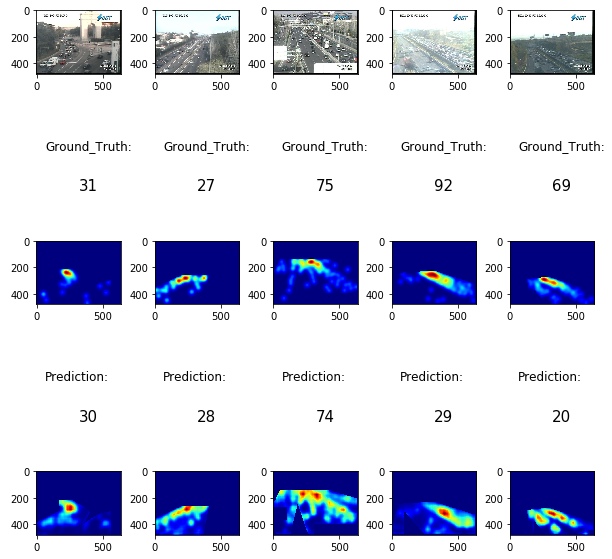

In [132]:
#fig = plt.figure()
#fig.subplots_adjust(hspace=0.05, wspace=0.4)
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(5):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(Image.open(sample_df['im_path'][i]))

for i in range(5):
    ax = fig.add_subplot(5, 5, i+6)
    ax.axis('off')
    ax.text(0.5, 0.1, int(sample_df['ntrue'][i]), fontsize=15)
    ax.text(0.1, 0.6, "Ground_Truth:", fontsize=12)
    
for i in range(5):
    ax = fig.add_subplot(5, 5, i+11)
    ax.imshow(sample_df['dens_im'][i],cmap=CM.jet)


for i in range(5):
    ax = fig.add_subplot(5, 5, i+16)
    ax.axis('off')
    ax.text(0.5, 0.1, int(sample_df['npred'][i]), fontsize=15)
    ax.text(0.1, 0.6, "Prediction:", fontsize=12)
    
for i in range(5):
    ax = fig.add_subplot(5, 5, i+21)
    ax.imshow(sample_df['resImg'][i],cmap=CM.jet) 



5) Additional analysis and comments.

Now, we are going to carry out some graphycal analysis.
We will start analyzing whether there is any association between the ground_truth (actual density) and the prediction error

In [42]:
#We will use "altair" library:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

The source data set is:

In [43]:
csv_test.head()

,img,ndots,ntrue,npred,error
0,3-000421,35.0,33.091682,51.260645,18.168963
1,3-000420,45.0,43.518074,41.013837,2.504237
2,3-000419,38.0,35.039540,34.221519,0.818021
3,3-000418,33.0,31.251856,37.867658,6.615802
4,3-000417,41.0,38.688330,38.268263,0.420067


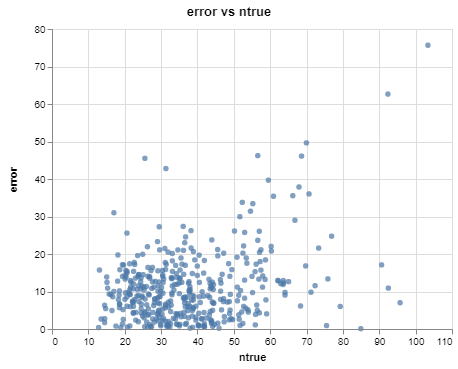

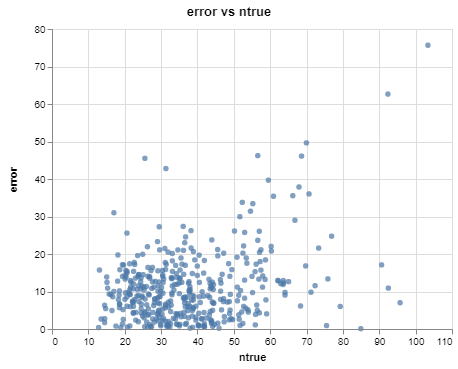

In [44]:
chart = alt.Chart(csv_test).mark_circle().encode(
    x='ntrue',
    y='error'
).properties(
    title='error vs ntrue',
    width=400,
    height=300
)

chart

It looks like: the more vehicles are, the higher the predicted error is

Let´s check how the error percentage behavies.
We will create the "error percentage" variable ('p_error') and have a look at the graphic: 
prediction error percentage (p_error) vs ground_truth (ntrue)

In [45]:
csv_test['p_error'] = abs(csv_test.ntrue-csv_test.npred)/csv_test.ntrue

In [46]:
chart_p = alt.Chart(csv_test).mark_circle().encode(
    x='ntrue',
    y='p_error'
).properties(
    title='p_error vs ntrue',
    width=400,
    height=300
)

In [47]:
total = (chart | chart_p) 

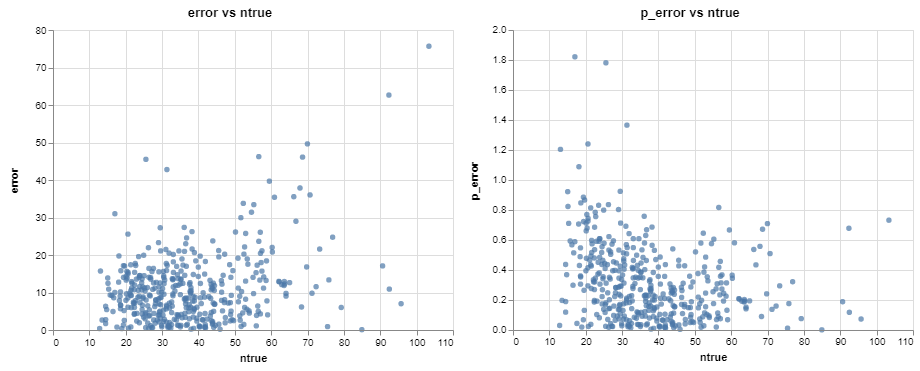

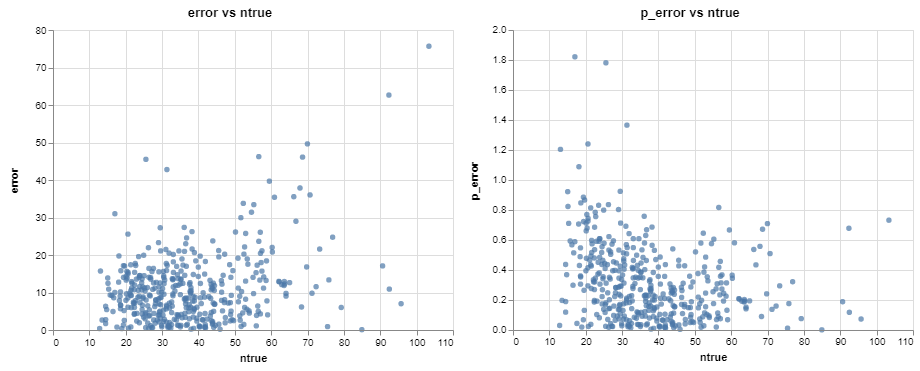

In [48]:
total

In [50]:
x = csv_test['ntrue']
y = csv_test['error']

x = sm.add_constant(x)
error_ntrue_model = sm.OLS(y,x).fit()

error_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     48.02
Date:                Fri, 09 Nov 2018   Prob (F-statistic):           1.60e-11
Time:                        15:28:20   Log-Likelihood:                -1510.3
No. Observations:                 421   AIC:                             3025.
Df Residuals:                     419   BIC:                             3033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6106      1.136      3.178      0.002       1.377       5.844
ntrue          0.1940      0.028      6.930      0.000       0.139       0.249
==============================================================================
Omnibus:                      153.447   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.254
Skew:                           1.582   Prob(JB):                    1.02e-136
Kurtosis:                       8.069   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a significant variance and we cannot see a clear association between ground_true values and prediction error.
Maybe, prediciton error is more associated to density of vehicles than to their number.

In order to analyze the association between "traffic density" and "prediction error", we will 
define two functions as follows:

"avg_min_euc_distance": This function returns the average euclidean distance between each object and its closest one.
We will use this function to measure the degree of concentration of the annotated vehicles.

"n_min_euc_distances": 






chart_p_dist = alt.Chart(test_w_dist).mark_circle().encode(
    x='AvgDistance',
    y='p_error'
).properties(
    title='p_error vs ntrue',
    width=400,
    height=300
) 

In [51]:
def avg_min_euc_distance(coord_list):
    
    '''
    This function returns the average euclidean distance between each object and its closest one
    In this project, an object is an annotated vehicle.
    
    @param: coord_list: List of coordinates of the objects
    
    '''
    
    list_len = len(coord_list) #number of coordinates
    
    distances = np.zeros((list_len,list_len)) #To store distances between coordinates 
    
    #Iterates over a list of coordinates, calculating the euclidean distance between 
    #every pair of coordinates (objects) of the list
    for i,x in enumerate(coord_list):
        for j,y in enumerate(coord_list):
            distances[i,j] = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
            
    
    min_distances = [] #List of minimum distances
    
    #Iterates over objects (rows) to collect the distance of each object to its closest one
    for ind,dist in enumerate(distances):
        n_clean = list(dist) #List of distances of a given object to the rest
        del n_clean[ind] #Cleanning the distance to of an item to itself, which is "0"
        min_dist = min(n_clean) #Distance of a given object to its closest one
        min_distances.append(min_dist)
        
        
    return np.sum(min_distances)/list_len   

As mentioned above, this function will measure the degree of concentration of annotated vehicles
and we will use it to measure traffic density.

The input for this function will be the files with the coordinates of the annotated vehicles that are included in TRANCOS data_set.
They have the same name as the images but their extension is "txt" instead "jpg".

We will apply this function to every input to obtain the traffic density value for each image ("AvgDistance",
save these data in a data_frame, and, merge it with the data_frame we have been using so far (csv_test).


In [54]:
df_list = []

for img_path in img_paths:
 
    x=[]
    y=[]
    
    with open(img_path.replace('.jpg','.txt'),'r') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            x.append(int(row[0]))
            y.append(int(row[1]))
        
    dots_gt = list(zip(x,y))
    dots_avg_dist = avg_min_euc_distance(dots_gt)
        
    img_number = str(img_path[-12:-4])
        
    row = [img_number, dots_avg_dist]
   
    df_list.append(row)

df_distances =  pd.DataFrame(df_list, columns=['img', 'AvgDistance']) 
df_distances.head()

,img,AvgDistance
0,3-000001,22.569088
1,3-000002,22.998472
2,3-000003,22.641467
3,3-000004,24.128208
4,3-000005,22.773655


In [55]:
test_w_dist = pd.merge(csv_test, df_distances)
test_w_dist.head()

,img,ndots,ntrue,npred,error,p_error,AvgDistance
0,3-000421,35.0,33.091682,51.260645,18.168963,0.549049,25.794950
1,3-000420,45.0,43.518074,41.013837,2.504237,0.057545,27.574061
2,3-000419,38.0,35.039540,34.221519,0.818021,0.023346,25.463029
3,3-000418,33.0,31.251856,37.867658,6.615802,0.211693,27.323775
4,3-000417,41.0,38.688330,38.268263,0.420067,0.010858,21.105020


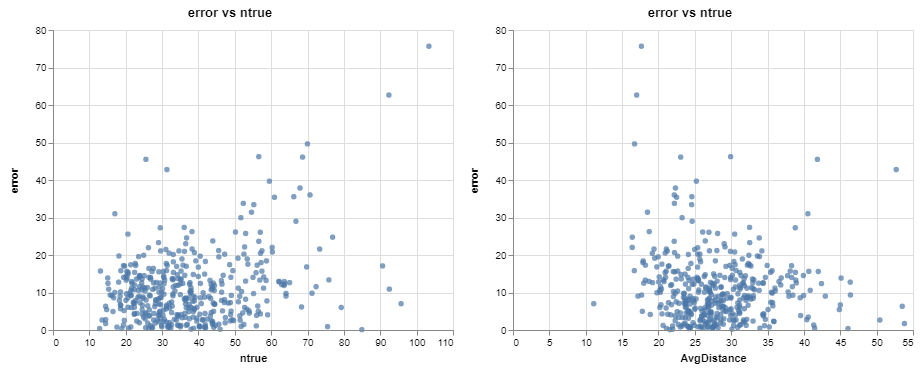

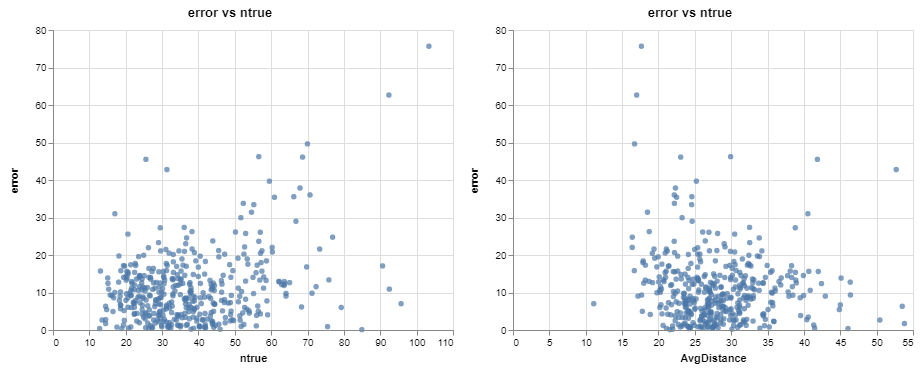

In [56]:
chart_dist = alt.Chart(test_w_dist).mark_circle().encode(
    x='AvgDistance',
    y='error'
).properties(
    title='error vs ntrue',
    width=400,
    height=300
) 

chart | chart_dist

In [57]:
x = test_w_dist['AvgDistance']
y = test_w_dist['error']

x = sm.add_constant(x)
density_ntrue_model = sm.OLS(y,x).fit()

density_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.218
Date:                Fri, 09 Nov 2018   Prob (F-statistic):             0.0406
Time:                        15:29:19   Log-Likelihood:                -1531.0
No. Observations:                 421   AIC:                             3066.
Df Residuals:                     419   BIC:                             3074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.9962      2.042      7.345      0.000      10.983      19.009
AvgDistance    -0.1452      0.071     -2.054      0.041      -0.284      -0.006
==============================================================================
Omnibus:                      227.752   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1701.822
Skew:                           2.229   Prob(JB):                         0.00
Kurtosis:                      11.783   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
def n_min_euc_distances(coord_list, threshold):
    
    list_len = len(coord_list)
    
    distances = np.zeros((list_len,list_len))
    
    for i,x in enumerate(coord_list):
        for j,y in enumerate(coord_list):
            distances[i,j] = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
            
    
    min_distances = []
    
    for ind,dist in enumerate(distances):
        n_clean = list(dist)
        del n_clean[ind]
        min_dist = min(n_clean)
        if min_dist<threshold:
            min_distances.append(min_dist)
        
        
    return len(min_distances)  

In [59]:
df_list = []
threshold = 15

for img_path in img_paths:
 
    x=[]
    y=[]
    
    with open(img_path.replace('.jpg','.txt'),'r') as f:
        reader = csv.reader(f,delimiter='\t')
        for row in reader:
            x.append(int(row[0]))
            y.append(int(row[1]))
        
    dots_gt = list(zip(x,y))
    
    dots_below_th = n_min_euc_distances(dots_gt,threshold)
        
    img_number = str(img_path[-12:-4])
        
    row = [img_number, dots_below_th]
   
    df_list.append(row)

df_dots_below_th =  pd.DataFrame(df_list, columns=['img', 'belowThreshold']) 



In [60]:
test_w_dist2 = pd.merge(test_w_dist, df_dots_below_th)
test_w_dist2.head()

,img,ndots,ntrue,npred,error,p_error,AvgDistance,belowThreshold
0,3-000421,35.0,33.091682,51.260645,18.168963,0.549049,25.794950,13
1,3-000420,45.0,43.518074,41.013837,2.504237,0.057545,27.574061,10
2,3-000419,38.0,35.039540,34.221519,0.818021,0.023346,25.463029,12
3,3-000418,33.0,31.251856,37.867658,6.615802,0.211693,27.323775,4
4,3-000417,41.0,38.688330,38.268263,0.420067,0.010858,21.105020,17


In [61]:
alt.renderers.enable('notebook')

chart_below = alt.Chart(test_w_dist2).mark_circle().encode(
    x='belowThreshold',
    y='error'
).properties(
    title='error vs n_below_threshold',
    width=400,
    height=300
)# .interactive()

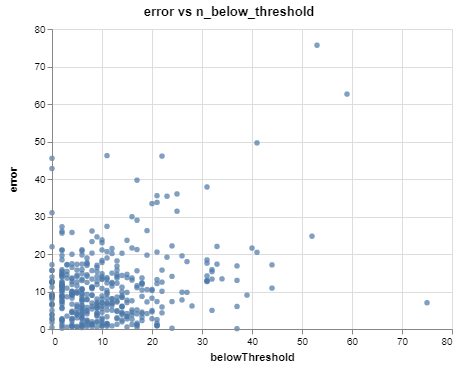

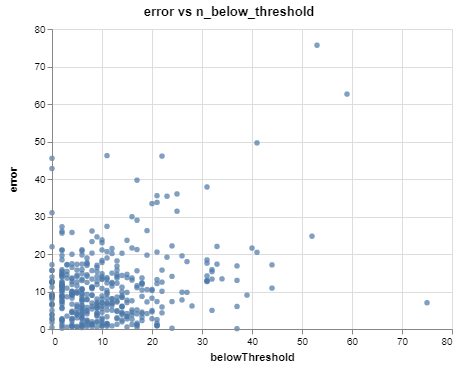

In [62]:
chart_below

In [63]:
test_w_dist2[['belowThreshold', 'ntrue']]

,belowThreshold,ntrue
0,13,33.091682
1,10,43.518074
2,12,35.039540
3,4,31.251856
4,17,38.688330
5,6,32.786575
6,14,40.369740
7,12,31.229320
8,41,69.969510
9,37,62.105870


In [64]:
x = test_w_dist2['belowThreshold']
y = test_w_dist2['error']

x = sm.add_constant(x)
theshold_ntrue_model = sm.OLS(y,x).fit()

theshold_ntrue_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     34.85
Date:                Fri, 09 Nov 2018   Prob (F-statistic):           7.35e-09
Time:                        15:29:28   Log-Likelihood:                -1516.3
No. Observations:                 421   AIC:                             3037.
Df Residuals:                     419   BIC:                             3045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.0448      0.650     12.375      0.000       6.767       9.323
belowThreshold     0.2544      0.043      5.904      0.000       0.170       0.339
==============================================================================
Omnibus:                      171.273   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              771.639
Skew:                           1.751   Prob(JB):                    2.76e-168
Kurtosis:                       8.632   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

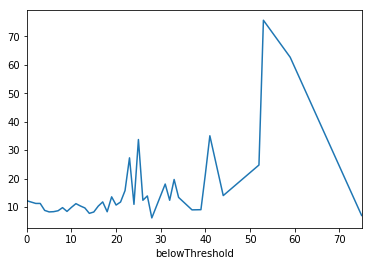

In [65]:
summary_df = test_w_dist2.groupby('belowThreshold')['error'].mean()  

summary_df.plot()


In [66]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html

In [67]:
x_bt = test_w_dist2['belowThreshold']
y_er = test_w_dist2['error']

bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(x_bt, y_er, statistic='mean', bins=3, range=None)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

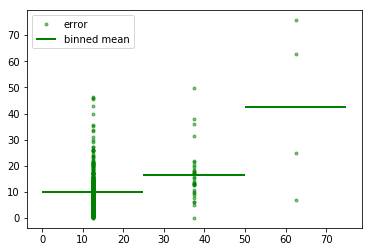

In [68]:
plt.figure()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2, label='binned mean')
plt.plot((binnumber - 0.5) * bin_width, y_er, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

In [69]:
image_cam = pd.read_csv('./image_cam.csv')
image_cam.head()

,img,cam
0,3-000001,cam206
1,3-000002,cam206
2,3-000003,cam206
3,3-000004,cam206
4,3-000005,cam206


In [70]:
test_w_dist2_cam = pd.merge(test_w_dist2, image_cam)
test_w_dist2_cam.head()

,img,ndots,ntrue,npred,error,p_error,AvgDistance,belowThreshold,cam
0,3-000421,35.0,33.091682,51.260645,18.168963,0.549049,25.794950,13,cam510
1,3-000420,45.0,43.518074,41.013837,2.504237,0.057545,27.574061,10,cam510
2,3-000419,38.0,35.039540,34.221519,0.818021,0.023346,25.463029,12,cam510
3,3-000418,33.0,31.251856,37.867658,6.615802,0.211693,27.323775,4,cam510
4,3-000417,41.0,38.688330,38.268263,0.420067,0.010858,21.105020,17,cam510


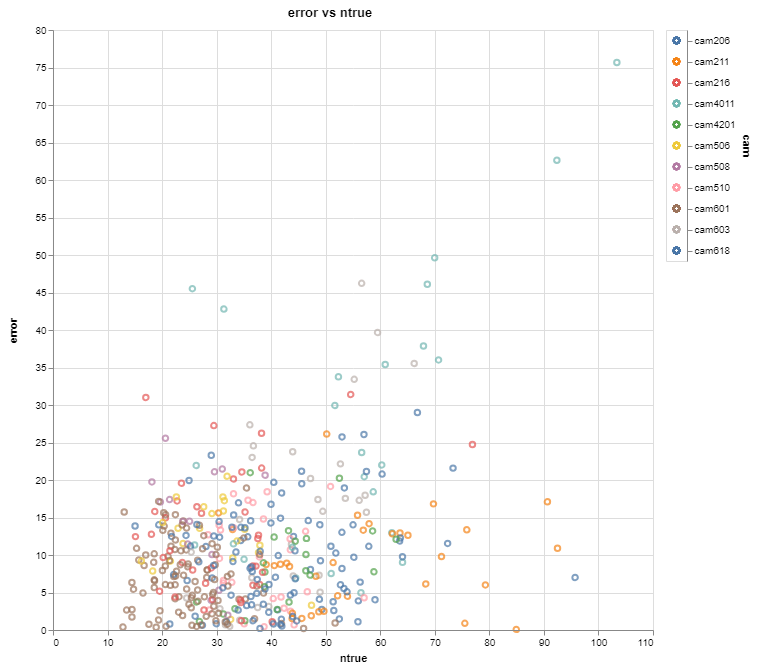

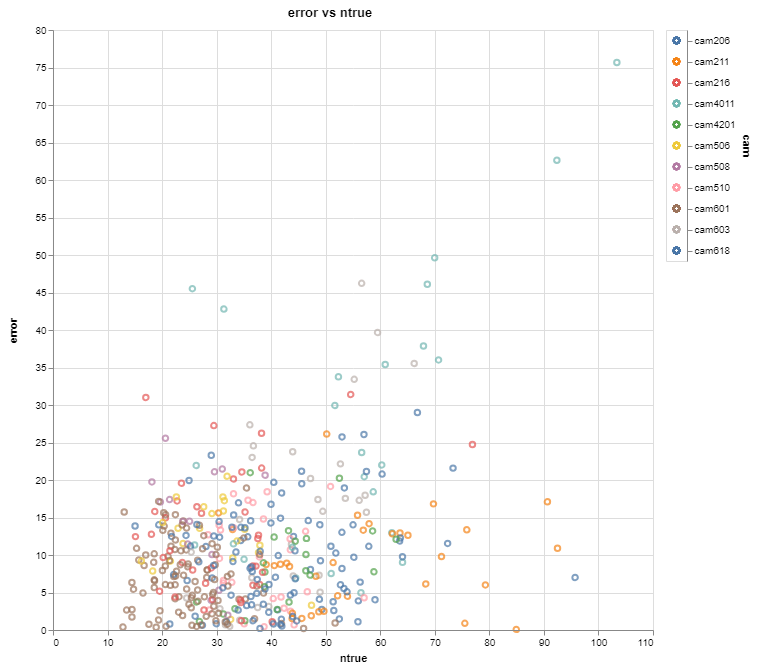

In [71]:
selection = alt.selection_multi(fields=['cam'])
color = alt.condition(selection,
                      alt.Color('cam:N', legend=None),
                      alt.value('lightgray'))

scatter = alt.Chart(test_w_dist2_cam).mark_point().encode(
    x='ntrue:Q',
    y='error:Q',
    color=color,
    tooltip='img:N'
).properties(
    title='error vs ntrue',
    width=600,
    height=600
)

legend = alt.Chart(test_w_dist2_cam).mark_point().encode(
    y=alt.Y('cam:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

scatter | legend